### Loading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load in data
train_features = pd.read_csv('data/training_set_features.csv')
train_labels = pd.read_csv('data/training_set_labels.csv')

train_df = pd.merge(train_labels, train_features, on='respondent_id')
train_df.set_index('respondent_id', inplace=True)

In [3]:
# Examine the dataset's shape
print(f'train_df.shape: {train_df.shape}')

train_df.shape: (26707, 37)


In [4]:
# Examine the dataset's datatypes
train_df.dtypes

h1n1_vaccine                     int64
seasonal_vaccine                 int64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                     

### Choosing our target

In [5]:
# Examine the vaccination value counts
for vaccine in ['seasonal_vaccine', 'h1n1_vaccine']:
    print(train_df[vaccine].value_counts())

# Given that seasonal vaccine has a better class balance, we'll choose that as our target

0    14272
1    12435
Name: seasonal_vaccine, dtype: int64
0    21033
1     5674
Name: h1n1_vaccine, dtype: int64


### Handling Nulls

In [6]:
train_df.isnull().sum()

h1n1_vaccine                       0
seasonal_vaccine                   0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
i

In [7]:
missing_data = train_df.isnull().sum()
missing_data_pct = missing_data / len(train_df)
missing_data_pct[missing_data_pct > .3]

health_insurance         0.459580
employment_industry      0.499120
employment_occupation    0.504362
dtype: float64

In [8]:
train_df['health_insurance'].fillna(0, inplace=True)
train_df.drop(columns=['employment_industry', 'employment_occupation'], inplace=True)
train_df.shape

(26707, 35)

### Reconciling Datatypes

In [9]:
string_representations = [feature for feature in train_df.columns if train_df[feature].dtype == 'object']
string_representations

['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa']

In [10]:
train_df_encoded = pd.get_dummies(train_df, columns=string_representations)
encoded_columns = [col for col in train_df_encoded.columns if any(col.startswith(str_col) for str_col in string_representations)]
train_df_encoded[encoded_columns].dtypes

age_group_18 - 34 Years                     uint8
age_group_35 - 44 Years                     uint8
age_group_45 - 54 Years                     uint8
age_group_55 - 64 Years                     uint8
age_group_65+ Years                         uint8
education_12 Years                          uint8
education_< 12 Years                        uint8
education_College Graduate                  uint8
education_Some College                      uint8
race_Black                                  uint8
race_Hispanic                               uint8
race_Other or Multiple                      uint8
race_White                                  uint8
sex_Female                                  uint8
sex_Male                                    uint8
income_poverty_<= $75,000, Above Poverty    uint8
income_poverty_> $75,000                    uint8
income_poverty_Below Poverty                uint8
marital_status_Married                      uint8
marital_status_Not Married                  uint8


In [11]:
train_df_encoded.shape

(26707, 63)

### Examining Feature Correlations

In [12]:
corr_mat = train_df_encoded.corr()
corr_mat[corr_mat == 1] = np.nan
five_most_correlated = corr_mat.unstack().sort_values(
    ascending=False
).drop_duplicates()[:5]

print(five_most_correlated)

doctor_recc_seasonal         doctor_recc_h1n1                        0.591868
behavioral_large_gatherings  behavioral_outside_home                 0.584085
opinion_h1n1_risk            opinion_seas_risk                       0.564208
age_group_65+ Years          employment_status_Not in Labor Force    0.498880
opinion_seas_sick_from_vacc  opinion_h1n1_sick_from_vacc             0.491546
dtype: float64


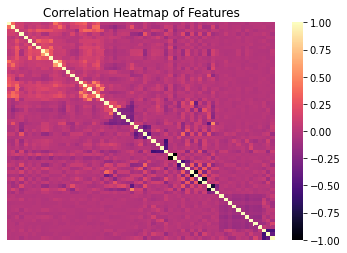

In [13]:

sns.heatmap(train_df_encoded.corr(), cmap='magma')
plt.title('Correlation Heatmap of Features')
plt.xticks([])
plt.yticks([]);

## Preparing for Model Building

In [14]:
from sklearn.model_selection import train_test_split

target = 'seasonal_vaccine' # We want to predict seasonal vaccine

# We choose behavioral features + doctor recommendations for the vaccines as our features.
chosen_features = [column for column in train_df if "behavioral" in column] + \
                  ['doctor_recc_h1n1' ,'doctor_recc_seasonal']

X = train_df_encoded[chosen_features]
y = train_df_encoded[target]

seed = 42 # For reproducability
test_size = .2 # 20% of our data will be in the testing set

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21365, 9), (5342, 9), (21365,), (5342,))

In [15]:
from sklearn.impute import SimpleImputer

def simple_impute(*Xs):
    results = []
    imputer = SimpleImputer(strategy='most_frequent')
    for X in Xs:
        X_imputed = imputer.fit_transform(X)
        X_imputed = pd.DataFrame(X_imputed, columns=X.columns)
        results.append(X_imputed)
    return tuple(results)

In [16]:
X_train, X_test = simple_impute(X_train, X_test)

print(f'Null values in X_train: {X_train.isnull().sum().sum()}')
print(f'Null values in X_test: {X_test.isnull().sum().sum()}')

Null values in X_train: 0
Null values in X_test: 0


In [17]:
print(f'Null values in y_train: {y_train.isnull().sum().sum()}')
print(f'Null values in y_test: {y_test.isnull().sum().sum()}')

Null values in y_train: 0
Null values in y_test: 0


## Building Models

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

def cv_conf_mat(model, model_name, X, y):
    # Cross-validation results
    cv = cross_validate(model, X, y, cv=5, return_train_score=True, scoring=['recall', 'f1', 'roc_auc'])
    cv_mean = {k: np.mean(v) for k, v in cv.items()}
    cv_df = pd.DataFrame.from_dict(cv_mean, orient='index').T
    cv_df = cv_df.rename(columns={n: n.replace('_', ' ').title() for n in cv_df.columns}).T
    cv_results = cv_df.drop(['Fit Time', 'Score Time']).T
    cv_results['Model'] = model_name

    # Confusion matrix
    model.fit(X, y)
    y_pred = model.predict(X)
    confusion_mat = confusion_matrix(y, y_pred)
    confusion_mat = pd.DataFrame(confusion_mat, columns=['0', '1'], index=['0', '1']).T
    confusion_mat.index.name = model_name
    
    return cv_results.set_index('Model'), confusion_mat

def plot_conf_mat(conf_mat):
    
    annot_labels = [
    ['TN: ' + str(conf_mat.iloc[0, 0]), 'FN: ' + str(conf_mat.iloc[0, 1])], 
    ['FP: ' + str(conf_mat.iloc[1, 0]), 'TP: ' + str(conf_mat.iloc[1, 1])]
    ]

    sns.heatmap(conf_mat, annot=annot_labels, fmt='', cmap='magma')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Confusion Matrix, {conf_mat.index.name}')
    plt.show()

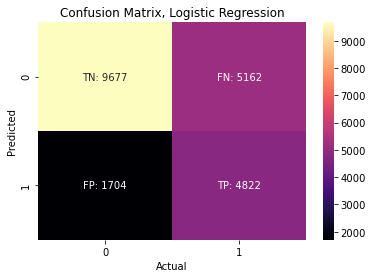

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700035,0.700491


In [19]:
model_1 = 'Logistic Regression'
baseline_model = make_pipeline(StandardScaler(), LogisticRegression(random_state=seed))
cv_baseline, conf_mat_baseline = cv_conf_mat(baseline_model, model_1, X_train, y_train)

plot_conf_mat(conf_mat_baseline)
display(cv_baseline)

In [20]:
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# Define parameter grid for Logistic Regression
param_grid = {
    'logisticregression__C': (0.001, 100, 'log_uniform'),
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Create the GridSearchCV object
random_search_baseline = RandomizedSearchCV(
    baseline_model, param_grid, cv=5, scoring='precision', n_iter=10, random_state=42
)

# Fit the GridSearchCV object to the training data
random_search_baseline.fit(X_train, y_train);

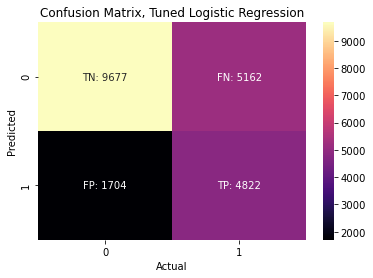

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700035,0.700491
Tuned Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700027,0.700489


In [21]:
baseline_tuned = random_search_baseline.best_estimator_
model_2 = 'Tuned Logistic Regression'
cv_tuned, conf_mat_tuned = cv_conf_mat(baseline_tuned, model_2, X_train, y_train)

# Results
plot_conf_mat(conf_mat_tuned)
stats_df = pd.concat([cv_baseline, cv_tuned])
stats_df

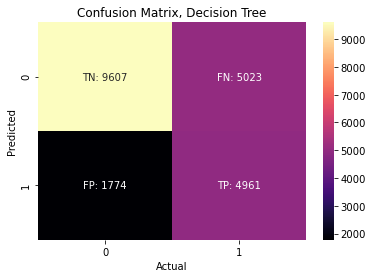

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700035,0.700491
Tuned Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700027,0.700489
Decision Tree,0.484776,0.494066,0.581709,0.592603,0.691312,0.714736


In [22]:
from sklearn.tree import DecisionTreeClassifier

model_3 = 'Decision Tree'
tree_model = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=seed))
cv_tree, conf_mat_tree = cv_conf_mat(tree_model, model_3, X_train, y_train)
stats_df = pd.concat([stats_df, cv_tree])

plot_conf_mat(conf_mat_tree)
stats_df

In [23]:
# Define parameter grid for Decision Tree
param_dist = {
    'decisiontreeclassifier__max_depth': [None] + list(range(1, 100)),
    'decisiontreeclassifier__min_samples_split': range(2, 100),
    'decisiontreeclassifier__min_samples_leaf': range(1, 100),
    'decisiontreeclassifier__criterion': ['gini', 'entropy']
}

# Create the RandomizedSearchCV object
random_search_tree = RandomizedSearchCV(
    tree_model, param_dist, cv=5, scoring='precision', n_iter=10, random_state=42, n_jobs=-1
)

# Fit the RandomizedSearchCV object to the training data
random_search_tree.fit(X_train, y_train);

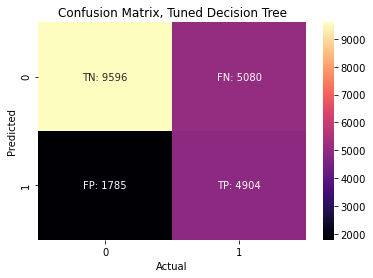

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700035,0.700491
Tuned Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700027,0.700489
Decision Tree,0.484776,0.494066,0.581709,0.592603,0.691312,0.714736
Tuned Decision Tree,0.485276,0.485727,0.584777,0.585526,0.696749,0.705485


In [24]:
model_4 = 'Tuned Decision Tree'
tuned_tree = random_search_tree.best_estimator_
cv_tuned_tree, conf_mat_tuned_tree = cv_conf_mat(tuned_tree, model_4, X_train, y_train)
stats_df = pd.concat([stats_df, cv_tuned_tree])

# Results
plot_conf_mat(conf_mat_tuned_tree)

stats_df

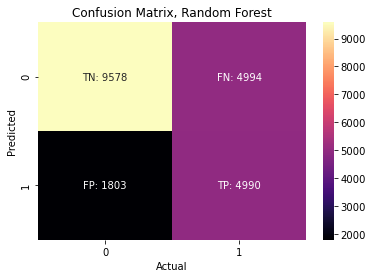

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700035,0.700491
Tuned Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700027,0.700489
Decision Tree,0.484776,0.494066,0.581709,0.592603,0.691312,0.714736
Tuned Decision Tree,0.485276,0.485727,0.584777,0.585526,0.696749,0.705485
Random Forest,0.488382,0.496795,0.583760,0.593933,0.691192,0.714471


In [25]:
from sklearn.ensemble import RandomForestClassifier

model_5 = 'Random Forest'
forest_model = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=seed))
cv_forest, conf_mat_forest = cv_conf_mat(forest_model, model_5, X_train, y_train)
stats_df = pd.concat([stats_df, cv_forest])

plot_conf_mat(conf_mat_forest)
stats_df

In [26]:
# Define parameter grid for Random Forest
param_dist_rf = {
    'randomforestclassifier__n_estimators': range(50, 200),
    'randomforestclassifier__max_features': ['auto', 'sqrt'],
    'randomforestclassifier__max_depth': [None] + list(range(5, 50)),
    'randomforestclassifier__min_samples_split': range(2, 20),
    'randomforestclassifier__min_samples_leaf': range(1, 20),
    'randomforestclassifier__bootstrap': [True, False]
}

# Create the RandomizedSearchCV object
random_search_rf = RandomizedSearchCV(
    forest_model, param_dist_rf, cv=5, scoring='precision', n_iter=10, random_state=seed, n_jobs=-1
)

# Fit the RandomizedSearchCV object to the training data
random_search_rf.fit(X_train, y_train);

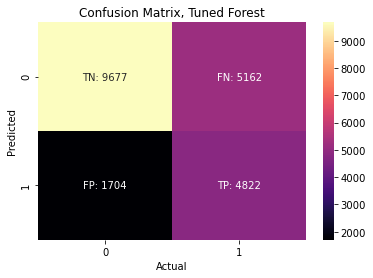

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700035,0.700491
Tuned Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700027,0.700489
Decision Tree,0.484776,0.494066,0.581709,0.592603,0.691312,0.714736
Tuned Decision Tree,0.485276,0.485727,0.584777,0.585526,0.696749,0.705485
Random Forest,0.488382,0.496795,0.583760,0.593933,0.691192,0.714471
Tuned Forest,0.482973,0.483073,0.584057,0.584241,0.698379,0.707647


In [27]:
model_6 = 'Tuned Forest'
tuned_forest = random_search_rf.best_estimator_
cv_tuned_forest, conf_mat_tuned_forest = cv_conf_mat(tuned_forest, model_6, X_train, y_train)
stats_df = pd.concat([stats_df, cv_tuned_forest])

plot_conf_mat(conf_mat_tuned_forest)
stats_df

In [28]:
new_features = chosen_features.copy()
new_features += [
    col for col in train_df_encoded.columns if 'opinion' in col or 'education' in col or col == 'h1n1_vaccine'
]

len(new_features)

20

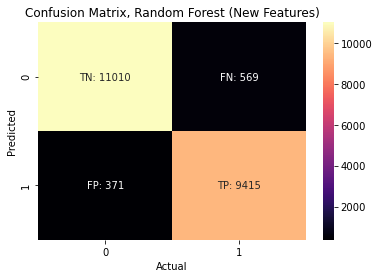

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700035,0.700491
Tuned Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700027,0.700489
Decision Tree,0.484776,0.494066,0.581709,0.592603,0.691312,0.714736
Tuned Decision Tree,0.485276,0.485727,0.584777,0.585526,0.696749,0.705485
Random Forest,0.488382,0.496795,0.583760,0.593933,0.691192,0.714471
Tuned Forest,0.482973,0.483073,0.584057,0.584241,0.698379,0.707647
Random Forest (New Features),0.731069,0.947541,0.735706,0.956897,0.826883,0.992852


In [29]:
model_7 = 'Random Forest (New Features)'
X_new = train_df_encoded[new_features].copy()

X_train_new, X_test_new, _, _ = train_test_split(X_new, y, random_state=seed, test_size=test_size)
X_train_new, X_test_new = simple_impute(X_train_new, X_test_new)

cv_forest_new_features, conf_mat_forest_new_features = cv_conf_mat(
    forest_model, model_7, X_train_new, y_train
)
stats_df = pd.concat([stats_df, cv_forest_new_features])
plot_conf_mat(conf_mat_forest_new_features)
stats_df

In [30]:
random_search_rf.fit(X_train_new, y_train);

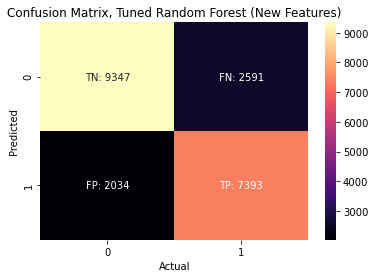

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700035,0.700491
Tuned Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700027,0.700489
Decision Tree,0.484776,0.494066,0.581709,0.592603,0.691312,0.714736
Tuned Decision Tree,0.485276,0.485727,0.584777,0.585526,0.696749,0.705485
Random Forest,0.488382,0.496795,0.583760,0.593933,0.691192,0.714471
Tuned Forest,0.482973,0.483073,0.584057,0.584241,0.698379,0.707647
Random Forest (New Features),0.731069,0.947541,0.735706,0.956897,0.826883,0.992852
Tuned Random Forest (New Features),0.728966,0.733248,0.754094,0.758665,0.851349,0.856939


In [31]:
model_8 = 'Tuned Random Forest (New Features)'
tuned_forest_model = random_search_rf.best_estimator_

cv_tuned_forest_new_features, conf_mat_tuned_forest_new_features = cv_conf_mat(
    tuned_forest_model, model_8, X_train_new, y_train
)

stats_df = pd.concat([stats_df, cv_tuned_forest_new_features])

plot_conf_mat(conf_mat_tuned_forest_new_features)
stats_df

In [35]:
stats_df.index

Index(['Logistic Regression', 'Tuned Logistic Regression', 'Decision Tree',
       'Tuned Decision Tree', 'Random Forest', 'Tuned Forest',
       'Random Forest (New Features)', 'Tuned Random Forest (New Features)'],
      dtype='object', name='Model')

In [32]:
from sklearn.metrics import recall_score, accuracy_score

y_pred = tuned_forest_model.predict(X_test_new)
test_recall = recall_score(y_pred, y_test)
test_accuracy = accuracy_score(y_pred, y_test)
print(f'''Recall Score for Tuned Random Forest Model with New Features:\t{test_recall}
Accuracy Score for Tuned Random Forest Model with New Features:\t{test_accuracy}''')

Recall Score for Tuned Random Forest Model with New Features:	0.7742906276870163
Accuracy Score for Tuned Random Forest Model with New Features:	0.7800449269936354


In [33]:
stats_df.to_csv('model_stats.csv')